<a href="https://colab.research.google.com/github/kameliaz/KAMELIA-MIDTERM/blob/main/Midterm_Q2(a).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
transform = transforms.Compose(
    #  transforms.Augmix(),
    #  transforms.CenterCrop()
    [transforms.Resize((32,32)), #fixed 224
     transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize([0.485], [0.229])]

    #  transforms.ToTensor(), # convert to 4d-tensor
    #  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

train_dir = '/content/drive/MyDrive/Covid19-dataset/train'
test_dir = '/content/drive/MyDrive/Covid19-dataset/test'

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform)

test_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform)


In [4]:
class_names = train_data.classes
class_names

['Covid', 'Normal', 'Viral Pneumonia']

In [5]:
img,label=train_data[0]
img.shape


torch.Size([1, 32, 32])

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,batch_size=4, shuffle=True)

test_dataloader = DataLoader(test_data,batch_size=4, shuffle=False)


In [7]:
# model_pretrained = models.densenet121(pretrained = True)

In [8]:
# model_pretrained

In [19]:
# !pip install torchinfo

# from torchinfo import summary

# summary(model=CNNModel)

In [11]:
# model_pretrained.classifier = nn.Linear(in_features=1024, out_features=2) #replace a new layer

In [12]:
# model_pretrained

In [20]:
# DEFINE OUR MODEL
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel,self).__init__()
    self.conv1 = nn.Conv2d(1,6,5)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,10)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()

  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    out = self.fc2(x)

    return out

In [21]:
model = CNNModel()

In [22]:
model.to('cuda')

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [23]:
!pip install torchinfo

from torchinfo import summary

summary(model= model)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            156
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            48,120
├─Linear: 1-6                            1,210
├─ReLU: 1-7                              --
├─Flatten: 1-8                           --
Total params: 51,902
Trainable params: 51,902
Non-trainable params: 0

In [26]:
# cross-entropy loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [27]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

    return best_model, history



In [28]:
num_epochs = 10
trained_CNNmodel, history = train_and_validate(model,loss_fn,optimizer,
                                            train_dataloader,test_dataloader,
                                            num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 1.9456, Accuracy: 45.4183%, 
		Validation : Loss : 1.1570, Accuracy: 44.2231%, Time: 142.5733s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.7936, Accuracy: 66.9323%, 
		Validation : Loss : 0.6281, Accuracy: 72.1116%, Time: 18.3946s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.5056, Accuracy: 79.2829%, 
		Validation : Loss : 0.4958, Accuracy: 82.0717%, Time: 19.0829s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.5074, Accuracy: 81.6733%, 
		Validation : Loss : 0.3726, Accuracy: 86.0558%, Time: 18.0666s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.4849, Accuracy: 82.4701%, 
		Validation : Loss : 0.4758, Accuracy: 83.2669%, Time: 17.8732s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.4354, Accuracy: 86.8526%, 
		Validation : Loss : 0.3225, Accuracy: 89.6414%, Time: 18.2590s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3797, Accuracy: 85.2590%, 
		Validation : Loss : 0.3046, Accuracy: 89.2430%, Time: 18.5544s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.3320, Accur

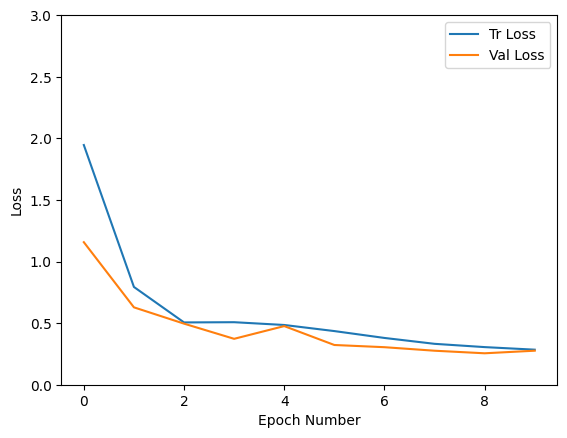

In [29]:
#Analyze the loss curve

def plot_loss(history):
  history = np.array(history)
  plt.plot(history[:,0:2])
  plt.legend(['Tr Loss', 'Val Loss'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.ylim(0,3)
  # plt.savefig('cifar10_loss_curve.png')
  plt.show()

plot_loss(history)

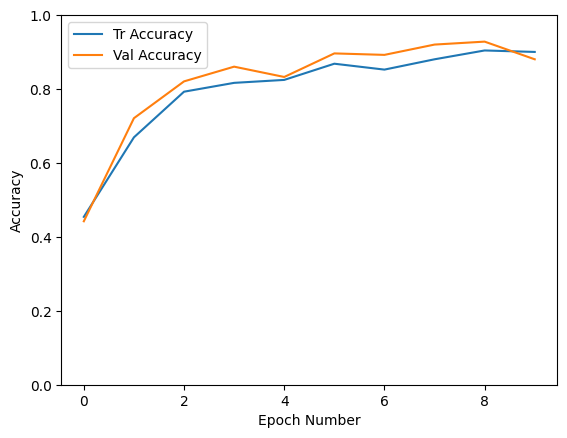

In [30]:
def plot_accuracy(history):
  history = np.array(history)
  plt.plot(history[:,2:4])
  plt.legend(['Tr Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  # plt.savefig('cifar10_accuracy_curve.png')
  plt.show()

plot_accuracy(history)

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sn
# import pandas as pd

# def plot_confusionMatrix(model_pretrained, test_dataloader):

#   y_pred = []
#   y_true = []

#   model_pretrained.to('cpu')

#   # iterate over test data
#   for inputs, labels in test_dataloader:
#           output = model_pretrained(inputs) # Feed Network

#           output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
#           y_pred.extend(output) # Save Prediction

#           labels = labels.data.cpu().numpy()
#           y_true.extend(labels) # Save Truth

#   # Build confusion matrix
#   cf_matrix = confusion_matrix(y_true, y_pred)
#   df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
#                       columns = [i for i in class_names])
#   plt.figure(figsize = (20,10))
#   sn.heatmap(df_cm, annot=True)
#   # plt.savefig('output.png')

# plot_confusionMatrix(model_pretrained, test_dataloader)